# Demonstration Notebook

Train a model to recognize notes from input sounds

## Part 1: Data Preparation and Exploration

By Ben Walsh \
For Bnaura

&copy; 2021 Ben Walsh <ben@bnaura.com>

## Contents

1. [Import Libraries](#lib_import)
1. [Data Import](#data_import)
1. [Data Exploration](#data_explore)
1. [Data Augmentation](#data_aug)
1. [Feature Extraction](#feat_extract)
1. [Save Features](#feat_save)


TO DO
- Improve data augmentation to be more efficient - lambda functions in dataframes
- Add column to database for train=1, test=0
- Generalize training functions to look for any files matching corresponding note tag
  - Add _Male2 recordings
- Submodule repo into simple_gui

In [1]:
%load_ext autoreload
%autoreload 2

## <a id = "lib_import"></a>1. Import Libraries

In [2]:
import sys
import os
import datetime
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import pickle
import sqlite3

from scipy.io import wavfile as wav
from IPython.display import Audio

# Add custom modules to path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import util.music_util as mus 
from util.ml_util import feat_extract, load_training_data
from util import DATA_FOLDER, SCALE


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
../1_audio\hum\Hum_Db4.wav does not exist
../1_audio\hum\Hum_Eb4.wav does not exist
../1_audio\hum\Hum_Gb4.wav does not exist
../1_audio\hum\Hum_Ab4.wav does not exist
../1_audio\hum\Hum_Bb4.wav does not exist
../1_audio\hum\Hum_B4.wav does not exist


## <a id = "data_import"></a>2. Data Import

In [3]:
X, y, fs = load_training_data(SCALE)

C:\Users\benja\Documents\Python\note-recognition\util\ml_util.py:96: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, signal = wav.read(training_data[note])


## <a id = "data_explore"></a> 3. Data Exploration

### Overview
Sanity check the dimensions of X and y

In [4]:
print('X is a {} with shape {}'.format(type(X), X.shape))
print('X has {} rows, and expected # of rows from notes = {}'.format(X.shape[0], len(SCALE)))
print('X sample length is {}'.format(X.shape[1]))
print('y has {} samples, and expected # of samples from notes = {}'.format(len(y), len(SCALE)))

X is a <class 'numpy.ndarray'> with shape (6, 120000)
X has 6 rows, and expected # of rows from notes = 6
X sample length is 120000
y has 6 samples, and expected # of samples from notes = 6


### Plot Waveform

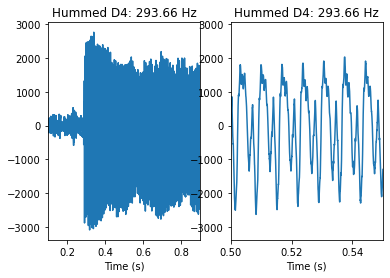

In [7]:
# Pick a note to plot
idx_test = 1
signal_test = X[idx_test,:]
note_test = SCALE[idx_test]

# Create array of time samples, converting number of samples and dividing by sample of frequency 
t_array = np.arange(X.shape[1])/fs

# Plot waveform over short time period to see sine
plt.subplot(121)
plt.xlim(0.1,0.9)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.plot(t_array, signal_test)

# Plot waveform over shorter time period to see sine
plt.subplot(122)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.plot(t_array, signal_test)

plt.show()


### Plot Frequency

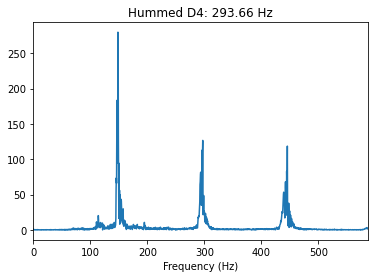

In [8]:
# Take FFT
ftransform = np.fft.fft(signal_test)/len(signal_test)
ftransform = ftransform[range(int(len(signal_test)/2))]
tp_count = len(signal_test)
vals = np.arange(tp_count/2)
t_period = tp_count/fs

# Scale to Hz frequency values for plotting
freqs = vals/t_period

plt.plot(freqs, abs(ftransform))
plt.xlim((0, 2*mus.note_to_freq[note_test]))
plt.xlabel('Frequency (Hz)')
plt.title('Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.show()

## <a id = "data_aug"></a> 4. Data Augmentation 

Synthesize dataset `aug_factor` times larger

In [9]:
aug_factor = 20

# Initialize matrix where each row contains a noisy sample
X_aug = np.empty((aug_factor*X.shape[0], X.shape[1]))
y_aug = pd.DataFrame(np.empty((aug_factor*X.shape[0], 1)), columns=['note'])

### 4.1 Add time shifts

Demonstrate time shift code

In [10]:
arr1 = np.array(np.arange(1,6))
print(arr1)
print(mus.add_timeshifts(arr1, samp_shift_max=4, debug=True))

[1 2 3 4 5]
Shape of input array = (5,)
Input samp_shift_max = 4
Random prepad_len = 3
[0. 0. 0. 1. 2.]


Apply time shifts to augmented training data

In [11]:
# Add random time shifts noise to each element
T_SHIFT_MAX = 0.1 # seconds
DEBUG=False

for idx in range(X.shape[0]):
    for sample in range(aug_factor):
        X_aug[sample+aug_factor*idx,:] = mus.add_timeshifts(X[idx,:], samp_shift_max=np.int(T_SHIFT_MAX*fs), debug=DEBUG)
        
        # Initialize truth values in synthesized set
        y_aug.iloc[sample+aug_factor*idx,0] = SCALE[idx]

### 4.2 Add noise 
Add noise to original recordings

In [12]:
NOISE_AMPL = 100

# Add white noise to each element
for idx in range(X.shape[0]):
    for sample in range(aug_factor):
        X_aug[sample+aug_factor*idx,:] = mus.add_noise(X_aug[sample+aug_factor*idx,:], ampl=NOISE_AMPL)

Sanity check the dimensions of the augmented training set

In [13]:
print('X_aug has shape {}, with aug_factor = {}'.format(X_aug.shape, aug_factor))
print('Original X has shape {}'.format(X.shape))

X_aug has shape (120, 120000), with aug_factor = 20
Original X has shape (6, 120000)


### Plot example with added noise and shifts

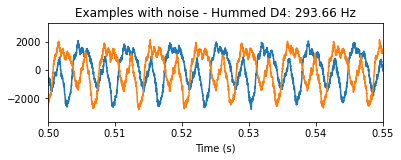

In [14]:
idx_test = 1
signal_test1 = X_aug[idx_test*aug_factor,:]
signal_test2 = X_aug[idx_test*aug_factor+6,:]
note_test = SCALE[idx_test]

# Plot waveform over shorter time period to see sine
plt.subplot(212)
plt.xlim(0.5 ,0.55)
plt.xlabel('Time (s)')
plt.title('Examples with noise - Hummed {}: {} Hz'.format(note_test, mus.note_to_freq[note_test]))
plt.plot(t_array, signal_test1)
plt.plot(t_array, signal_test2)

plt.show()

## <a id = "feat_extract"></a> 5. Feature Extraction 

In [16]:
X_feat = feat_extract(X_aug, fs, mus.note_to_freq, SCALE)

Feat extract: sample 100/120


In [17]:
X_feat.head()

,C4,D4,E4,F4,G4,A4
0,0.287540,0.150938,0.131997,0.188611,0.199334,0.041580
1,0.281649,0.146940,0.145490,0.189777,0.197736,0.038408
2,0.286860,0.145540,0.134470,0.199892,0.188895,0.044343
3,0.282689,0.157714,0.143730,0.201289,0.174747,0.039831
4,0.281952,0.140264,0.141009,0.187785,0.207563,0.041427


### Explore extracted features

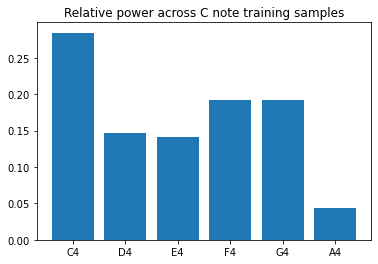

In [18]:
note_test = 'C'
plt.bar(SCALE, X_feat[y_aug['note'].str.contains(note_test)].mean())
plt.title('Relative power across {} note training samples'.format(note_test))
plt.show()

## <a id = "feat_save"></a> 6. Save Features

### Using SQL

In [19]:
FEAT_DB_NAME = os.path.join(DATA_FOLDER, 'features.db')
TABLE_NAME = 'X_all'
conn = sqlite3.connect(FEAT_DB_NAME)
c = conn.cursor()

# Create table
c.execute('''CREATE TABLE IF NOT EXISTS {}
             ({} real, {} real, {} real, 
             {} real, {} real, {} real)'''.format(TABLE_NAME, X_feat.columns[0],
                                                    X_feat.columns[1],
                                                 X_feat.columns[2],
                                                 X_feat.columns[3],
                                                 X_feat.columns[4],
                                                 X_feat.columns[5]))

# Commit the changes to db
conn.commit()

# Insert multiple records in a single query
c.executemany('INSERT INTO {} VALUES(?,?,?,?,?,?);'.format(TABLE_NAME), X_feat.values);
conn.commit()

# Close the connection
conn.close()

### Using CSV

Split data for training and testing and save off features

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y_aug, random_state=1)

if not(os.path.exists(DATA_FOLDER)):
    os.mkdir(DATA_FOLDER)

X_train.to_csv(os.path.join(DATA_FOLDER, 'X_train.csv'), index=False)
X_test.to_csv(os.path.join(DATA_FOLDER, 'X_test.csv'), index=False)

y_train.to_csv(os.path.join(DATA_FOLDER, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(DATA_FOLDER, 'y_test.csv'), index=False)